In [1]:
!nvidia-smi

Mon Apr 12 02:31:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/pytorch_pix2code"


Mounted at /content/drive
/content/drive/My Drive/pytorch_pix2code


In [ ]:
%cd "/content/drive/My Drive/pytorch_pix2code"

/content/drive/My Drive/pytorch_pix2code


In [ ]:
# Only run it if you don't have the repo
#!git clone https://github.com/VaibhavYadav/pytorch_pix2code.git #might change it to our github repo?

# ADJUSTING DATASET
no need to run this part unless
you manipulating the datasets
RUN ONLY ONCE

Running Code below to separate new dataset to training and evaluate dataset



In [ ]:
"""
%cd "/content/drive/My Drive"


import os
import numpy as np
from shutil import copyfile


input_path = './sketch2code/data'
output_path = 'pytorch_pix2code/sketch_dataset/'
eval_split_percent = 0.10


# List of every datapoint filename
paths = []
for f in os.listdir(input_path):
    if f.find('.gui') != -1:
        file_name = f[:f.find('.gui')]
        if os.path.isfile('{}/{}.png'.format(input_path, file_name)):
            paths.append(file_name)

# Split the data in training and evaluation set
eval_sample_number = int(len(paths) * eval_split_percent)
np.random.shuffle(paths)
eval_set = paths[:eval_sample_number]
train_set = paths[eval_sample_number:]

for path in eval_set:
    copyfile('{}/{}.png'.format(input_path, path), '{}/{}/{}.png'.format(os.path.dirname(output_path), 'evaluation', path))
    copyfile('{}/{}.gui'.format(input_path, path), '{}/{}/{}.gui'.format(os.path.dirname(output_path), 'evaluation', path))

for path in train_set:
    copyfile('{}/{}.png'.format(input_path, path), '{}/{}/{}.png'.format(os.path.dirname(output_path), 'training', path))
    copyfile('{}/{}.gui'.format(input_path, path), '{}/{}/{}.gui'.format(os.path.dirname(output_path), 'training', path))


converting some sketch images to 4 channels (only need to be done once)

In [ ]:
'''
input_path = "/content/drive/My Drive/pytorch_pix2code/sketch_dataset/training"
output_path = "/content/drive/My Drive/pytorch_pix2code/sketch_dataset2/training"

import glob
def png2pnga(path_open, path_save, files):
    for name in glob.glob(path_open + files): 
        if name.find('.png') != 1:
            im = Image.open(name).convert('RGBA')
            im.save(path_save + name[len(path_open):], "PNG", quality=100)
png2pnga(input_path, output_path, "/*.png")
'''

Moving Gui to new destination

In [ ]:
'''
from shutil import copyfile
import os

paths = []
for f in os.listdir(input_path):
    if f.find('.gui') != -1:
        file_name = f[:f.find('.gui')]
        if os.path.isfile('{}/{}.png'.format(input_path, file_name)):
            paths.append(file_name)
for path in paths:
    print(path)
    copyfile('{}/{}.gui'.format(input_path, path), '{}/{}.gui'.format(output_path, path))
'''

Deleting some Gui files in the Desired Folder

In [ ]:
"""
from shutil import copyfile
import os
input_path = r"/content/drive/My Drive/pytorch_pix2code/sketch_dataset2/evaluation"
paths = []
for f in os.listdir(input_path):
    if f.find('.gui') != -1:
        os.remove(f"{input_path}/{f}")
"""


# IMPORTING LIBRARIES

In [3]:
from util import UIDataset, Vocabulary, SketchDataset, SketchTest, UITest
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import DataLoader
from model import *
#from sketch_model import *
from torchvision import transforms
from PIL import Image

# LOADING DATASET

In [6]:
# dataset = UIDataset('./sketch_dataset/training', 'voc.pkl') # UIDataset is used for screenshots
dataset = SketchDataset('./sketch_dataset_new/training', './compiler/vocab.pkl') # SketchDataset is used for Sketches (.png only for now)

Sanity Check Test

torch.Size([3, 256, 256])


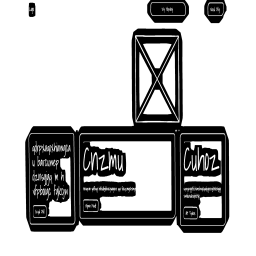

In [44]:
import cv2
#Shuffling the Dataset
loader = DataLoader(dataset,batch_size=75, shuffle=True) 
image, *_ = dataset.__getitem__(9)
print(image.shape)
t = transforms.ToPILImage()
image = image.unsqueeze(0)
t(image.squeeze())



# TRAINING

Hyper Parameters & defining Model

In [ ]:
input_size = 28
model = Pix2Code(input_size).cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 10
model_output_name = 'Sketch2Code_v4'

Training

In [40]:
for epoch in range(epochs):
    model.zero_grad()

    for j, data in enumerate(loader):
        # Extracting Dataset 
        image, context, expected_output = data   

        #image = image.unsqueeze(0).cuda()
        #context = context.unsqueeze(0).cuda()
        #image = image.cuda()
        #context = context.cuda()
        expected_output = expected_output.cuda()
        # Forward Propagation, Loss, and Back-Propagation
        output = model(image, context)
        output = output.squeeze(0)
        expected_output = torch.argmax(expected_output, 1)
        
        loss = loss_fn(output, expected_output)
        loss.backward()

        # Updating weights every 10 steps, and resetting gradients (since it accumulates in Pytorch)
        if j%10 == 0:
            optimizer.step()
            print('Loss: {}, Epoch: {}'.format(loss.data, epoch))
            model.zero_grad()

    torch.save(model.state_dict(), f"./model_weights/{model_output_name}.weights")

Loss: 3.328197956085205, Epoch: 0
Loss: 3.2559142112731934, Epoch: 0
Loss: 3.1718904972076416, Epoch: 0
Loss: 3.022108316421509, Epoch: 0
Loss: 2.8318932056427, Epoch: 0
Loss: 2.6593616008758545, Epoch: 0
Loss: 2.4772450923919678, Epoch: 0
Loss: 2.3386759757995605, Epoch: 0
Loss: 2.266557216644287, Epoch: 0
Loss: 2.2563796043395996, Epoch: 0
Loss: 2.1964049339294434, Epoch: 0


KeyboardInterrupt: ignored

# TESTING

In [ ]:
input_size = 28
model = Pix2Code(input_size)
model.load_state_dict(torch.load(f"./model_weights/{model_output_name}.weights"))
model.cuda().eval()

Pix2Code(
  (image_encoder): ImageEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=100352, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (context_encoder): ContextEncoder(
    (rnn): RNN(28, 128, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): RNN(1152, 512, num_layers=2, batch_first=True)
    (l1): Linear(in_features=512, out_features=28, bias=True)
  )
)

In [ ]:
#test_data = UIDataset('./sketch_dataset/evaluation', 'voc.pkl')
#test_data = SketchTest('./validation', 'voc.pkl')
test_data = SketchTest('./sketch_dataset_new/training', './compiler/vocab.pkl')

ValueError: ignored

Just to visualize our current tokens

In [ ]:
vocab = Vocabulary('./compiler/vocab.pkl')
vocab.index_to_vocab

{0: '\n',
 1: ' ',
 2: ',',
 3: '<END>',
 4: '<START>',
 5: 'btn-active',
 6: 'btn-green',
 7: 'btn-inactive',
 8: 'btn-orange',
 9: 'btn-red',
 10: 'double',
 11: 'header',
 12: 'quadruple',
 13: 'row',
 14: 'single',
 15: 'small-title',
 16: 'text',
 17: '{',
 18: '}',
 19: 'css-file-name',
 20: 'header-right',
 21: 'big-title',
 22: 'big-text',
 23: 'small-text',
 24: 'img',
 25: 'empty',
 26: 'container',
 27: 'btn'}

Visualizing the Preprocessed & Processed input image

0180


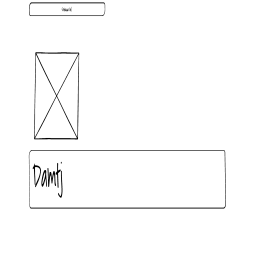

In [ ]:
output_name = f"{model_output_name}_Test_1" #Output Directory
index = np.random.randint(len(test_data))
#index = -1
image = test_data.__getitem__(index)
print(test_data.paths[index])
t = transforms.ToPILImage()
image = image.unsqueeze(0)
t(image.squeeze())
# unsqueezeing to insert into predictor

In [ ]:
image = image.cuda()
ct = [] #ct stands for context, and we put " " and "<START>" as our first input to trigger LSTM based on CNN
# Initializing context
ct.append(vocab.to_vec(' '))
ct.append(vocab.to_vec('<START>'))
output = ''   #This is the.gui file, doesn't need HTML code

# PREDICTING
for i in range(200):
    context = torch.tensor(ct).unsqueeze(0).float().cuda()
    index = torch.argmax(model(image, context), 2).squeeze()[-1:].squeeze()
    v = vocab.to_vocab(int(index))
    if v == '<END>':
        break
    output += v
    ct.append(vocab.to_vec(v))

with open(f"./compiler/{output_name}.gui", 'w') as f:
    f.write(output)
print(" ")
print("GUI OUTPUT: ")
print(output)

 
GUI OUTPUT: 
header{
quadruple{
btn-active
}
double{
btn-inactive
}
quadruple{
btn-active
}
}
container{
row{
single{
empty
}
}
row{
single{
big-text,text
}
}
}



In [ ]:
%cd compiler
!python web-compiler.py output/{output_name}.gui
%cd "/content/drive/My Drive/pytorch_pix2code"

/content/drive/My Drive/pytorch_pix2code/compiler
/content/drive/My Drive/pytorch_pix2code
